In [1]:
import cv2
import random
import json
from PIL import Image
import os
from torch.utils.data import Dataset, DataLoader
import torch, torchvision
import warnings
import numpy as np
from albumentations.pytorch.transforms import ToTensor
import albumentations as A
import pandas as pd
from tqdm.notebook import tqdm

warnings.filterwarnings("ignore")
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from tqdm import tqdm
from matplotlib import pyplot as plt
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

In [25]:
# !pip install opencv-python
# !pip install albumentations==0.5.2

In [26]:
# pip install kaggle

In [27]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/workspace/coursework-2025/'

import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

In [28]:
# api.dataset_download_files('xhlulu/flickrfaceshq-dataset-nvidia-part-1', path='data/real-faces')

In [29]:
# api.dataset_download_files('tunguz/alexkonse/disney-pic', path='data/fake-faces', quiet=False,)

In [201]:
# api.dataset_download_files('brendanartley/cartoon-faces-googles-cartoon-set', path='./', quiet=False,)

Dataset URL: https://www.kaggle.com/datasets/brendanartley/cartoon-faces-googles-cartoon-set


In [30]:
import torch
from torch import nn

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 4090


In [31]:
def plot_images(images_for_show, titles):
  """Строит изображение на одном графике"""
  fig = plt.figure(figsize=(16, 16))

  columns = len(images_for_show)
  rows = 1
  for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    ax.title.set_text(titles[i - 1])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(images_for_show[i - 1])
    
  fig.subplots_adjust(wspace=0.1, hspace=0)
  plt.show()

In [32]:
class ClassifierDataset(Dataset):
    def __init__(self, df):
        self.transforms = A.Compose([
              A.Resize(256, 256),
              A.Normalize(),
              ToTensor()
        ])
        self.df = df

    def __len__(self):
        return len(self.df)

    
    def _load_file(self, path):
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image

    def __getitem__(self, idx):
        now = self.df.iloc[idx]
        x = self._load_file(now['path'])
        y = now['label']
        transformed = self.transforms(image=x)['image']
        
        return transformed, y

In [174]:
data_dir = 'data'

paths = []
for el in os.walk(data_dir):
    for filename in el[-1]:
        if '.jpg' in filename or '.png' in filename:
            paths.append(os.path.join(el[0], filename))

# df = pd.DataFrame({'path': paths, 'label': 0})
# df = df[df['path'].apply(lambda x: '/fake-faces/' not in x)]
# df['label'] = df['path'].apply(lambda x: 'fake-faces' in x)
# df = pd.concat([df[df['label'] == 1][:7857], df[df['label'] == 0]])
df = pd.read_csv('labeled_bad_faces.csv')
df.head()

,path,label
0,data/my-fake-faces/real/seed_514326.jpg,False
1,data/my-fake-faces/real/seed_644497.jpg,True
2,data/my-fake-faces/real/seed_888971.jpg,True
3,data/my-fake-faces/real/seed_820142.jpg,False
4,data/my-fake-faces/real/seed_128798.jpg,False


In [199]:
transforms = A.Compose([
      A.Resize(256, 256),
      A.Normalize(),
      ToTensor()
])

def predict_image(x):
    input = transforms(image=x)['image'].to(device)
    input = input.reshape(-1, *input.shape)
    # input = torch.Tensor([input])
    pred = model(input)[0]
    return pred[0].item()

image = cv2.imread('data/my-fake-faces/real/seed_644497.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
predict_image(image)

0.5171074271202087

In [3]:
image.shape

NameError: name 'image' is not defined

In [198]:
input.shape

torch.Size([16, 3, 256, 256])

In [175]:
df['label'].value_counts()

label
False    362
True     138
Name: count, dtype: int64

In [176]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, shuffle=True)

In [196]:
test_df

,path,label
61,data/my-fake-faces/real/seed_837793.jpg,True
1,data/my-fake-faces/real/seed_644497.jpg,True
333,data/my-fake-faces/real/seed_460398.jpg,False
323,data/my-fake-faces/real/seed_897997.jpg,False
104,data/my-fake-faces/real/seed_60574.jpg,False
...,...,...
475,data/my-fake-faces/real/seed_219385.jpg,False
124,data/my-fake-faces/real/seed_590856.jpg,False
454,data/my-fake-faces/real/seed_607414.jpg,False
328,data/my-fake-faces/real/seed_796400.jpg,True


In [177]:
train_dataset = ClassifierDataset(train_df)
test_dataset = ClassifierDataset(test_df)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=8, shuffle=True)

In [178]:
batch = next(iter(train_loader))

In [179]:
model = models.resnet50(pretrained=True)

model.fc = nn.Sequential(
    nn.Linear(2048, 256),
    nn.ReLU(),
    nn.Linear(256, 1),
    nn.Sigmoid()
)

In [180]:
model = model.to(device)
criterion = nn.BCELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 3e-4)

In [181]:
model(batch[0].to(device)).shape

torch.Size([16, 1])

In [182]:
def train_epoch(model, batch_gen, criterion, optimizer, is_train = True) :
  epoch_loss = 0.0
  count = 0
  accuracy = 0
  model.train(is_train)
  
  for input, labels in tqdm(batch_gen) :
    input = input.to(device)
    labels = labels.to(device).reshape(-1, 1).to(torch.float)
    
    with torch.set_grad_enabled(is_train) :
      pred = model(input)
      loss = criterion(pred, labels)
      accuracy += torch.sum((pred > 0.5) == labels)
      
      if is_train :
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
      
      count += input.shape[0]
      epoch_loss += loss.item()

  return epoch_loss / count, accuracy / count

In [183]:
import copy

def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs) :
  best_acc = 0
  best_model = None

  loader = {'train' : train_loader, 'test' : test_loader}
  loss_history = {'train' : [], 'test' : []}
  acc_history = {'train' : [], 'test' : []}

  for epoch in range(num_epochs) :
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    for phase in ['train', 'test'] :
      epoch_loss, epoch_acc = train_epoch(model, loader[phase], criterion, optimizer, phase == 'train')
      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
      loss_history[phase].append(epoch_loss)
      acc_history[phase].append(epoch_acc)
    
    if best_acc < acc_history['test'][-1]:
      best_acc = acc_history['test'][-1]
      best_model = copy.deepcopy(model)

    print()
  
  return loss_history, acc_history, best_model

In [185]:
loss_train, acc_train, model = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=1)

Epoch 0/0
----------


100%|██████████| 25/25 [00:01<00:00, 12.55it/s]


train Loss: 0.0239 Acc: 0.8575


100%|██████████| 7/7 [00:01<00:00,  5.94it/s]

test Loss: 0.0302 Acc: 0.8400



In [186]:
# cartoon_path = os.path.join(data_dir, 'cartoon')
# paths = [os.path.join(cartoon_path, name) for name in os.listdir(cartoon_path)]
# labels = [int(name[name.find('_') + 1:-4]) for name in os.listdir(cartoon_path)]
# cartoon_df = pd.DataFrame({'path': paths, 'label': labels})

# full_dataset = ClassifierDataset(df[df['label'] == 0][7857:10000])
# full_loader = DataLoader(full_dataset, batch_size=batch_size, num_workers=8, shuffle=True)
# full_dataset[0][0].shape

In [187]:
full_loader = test_loader

In [188]:
mean=torch.Tensor([0.485, 0.456, 0.406])
std=torch.Tensor([0.229, 0.224, 0.225])
undo_norm = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

In [192]:
input.shape

torch.Size([16, 3, 256, 256])

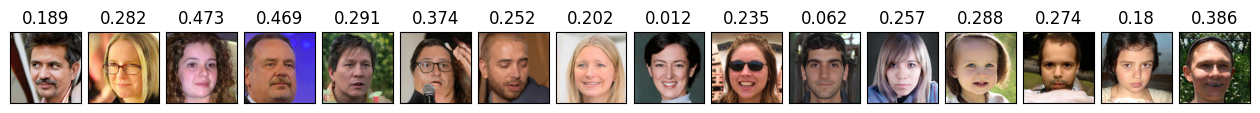

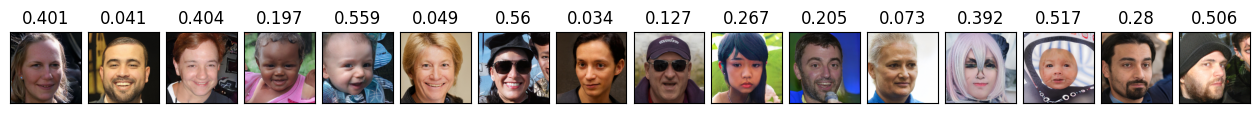

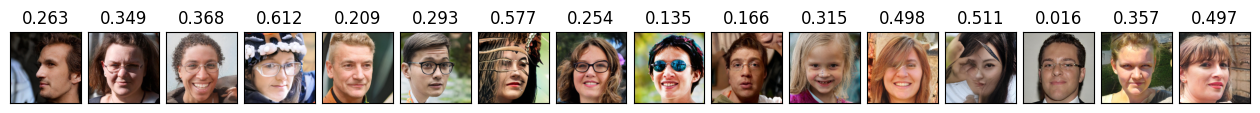

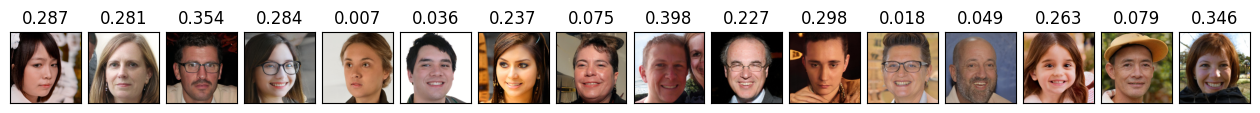

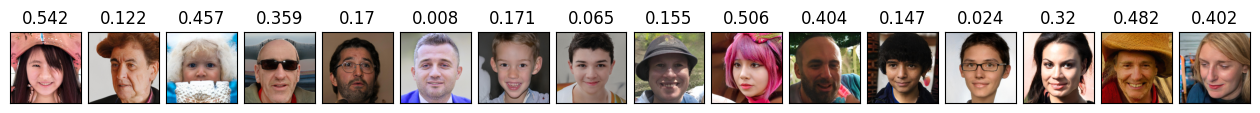

In [189]:
n = 5
for input, labels in full_loader:
    input = input.to(device)
    labels = labels.to(device).reshape(-1, 1).to(torch.float)
    pred = model(input).view(-1)
    pred = [round(el.item(), 3) for el in pred]
    plot_images(torch.moveaxis(undo_norm(input), 1, -1).cpu().detach().numpy(), pred)
    n -= 1
    if not n:
      break

In [ ]:
# test_df

In [167]:
preds = []
for input, labels in tqdm(test_loader):
    input = input.to(device)
    pred = model(input).view(-1)
   
    for p, seed in zip(pred, labels):
        preds.append(p.item())
test_df['pred'] = preds
test_df.head()

100%|██████████| 197/197 [00:14<00:00, 13.67it/s]


,path,label,pred
174540,data/real-faces/images1024x1024-20191222T22113...,False,0.798712
175778,data/real-faces/images1024x1024-20191222T22113...,False,0.943002
175161,data/real-faces/images1024x1024-20191222T22113...,False,0.000750
644,data/my-fake-faces/real/seed_274735.jpg,True,0.016811
645,data/my-fake-faces/real/seed_908823.jpg,True,0.012208


In [168]:
def plot_images_by_path(paths, titles, cols=10):
    res = []
    for path in paths:
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        res.append(image)
    plot_images(res, titles=titles)

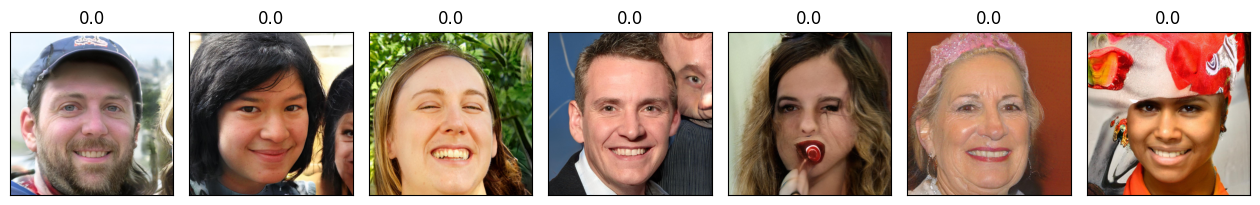

In [172]:
show = (test_df['label'] == 1) & (test_df['pred'] < 0.0001)
seed = random.randint(0, 1000)
plot_images_by_path(test_df[show]['path'].sample(7, random_state=seed).tolist(),
                    titles=test_df[show]['pred'].sample(7, random_state=seed).round(3).tolist())

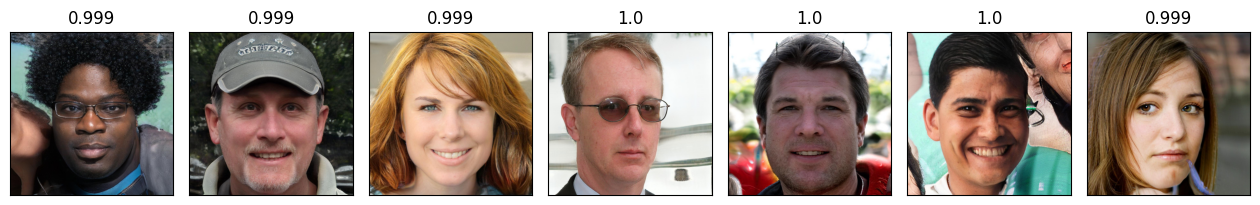

In [171]:
show = (test_df['label'] == 1) & (test_df['pred'] > 0.999)
seed = random.randint(0, 1000)
plot_images_by_path(test_df[show]['path'].sample(7, random_state=seed).tolist(),
                    titles=test_df[show]['pred'].sample(7, random_state=seed).round(3).tolist())

In [ ]:
res = {}
for input, labels in tqdm(full_loader):
    input = input.to(device)
    pred = model(input).view(-1)
   
    for p, seed in zip(pred, labels):
        res['seed_{}.jpg'.format(seed.item())] = p.item()

100%|██████████| 2401/2401 [09:15<00:00,  4.32it/s]


In [147]:
input.shape

torch.Size([7, 3, 256, 256])

In [126]:
(test_df[test_df['label'] == 1]['pred'] < 0.0001).sum()

121

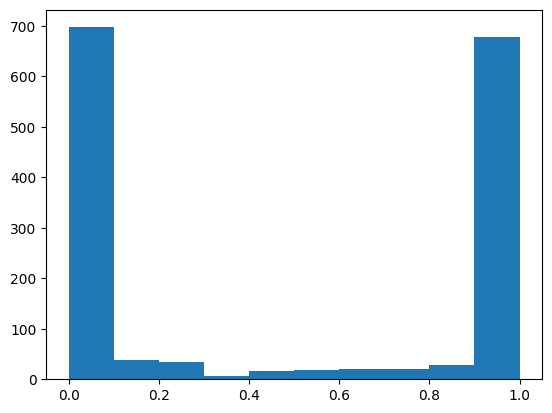

In [118]:
plt.hist(test_df[test_df['label'] == 1]['pred'].values)
plt.show()

In [ ]:
sum(np.array(list(res.values())) > 0.8)

8761

In [200]:
torch.save(model.state_dict(), 'models/bad_face_detection.pt')